In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import sqlite3 
import numpy as np
import json
import math
from tqdm.notebook import tqdm
from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import Advan_operator as ad_op  

pd.set_option('display.max_columns', None)

In [2]:
year = 2022
month = 11  # MONTH 8 is missed.

# landscan_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test\Landscan_daytime_2021_CBG.csv"
# landscan_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test\Landscan_nighttime_2021_CBG.csv"

# hourly_popu_fname = fr"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_population_hourly_{year}{month:02}.csv"
ACS_file = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv"

# desktop 2018
landscan_fname = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test\Landscan_daytime_2021_CBG.csv"
# hourly_popu_fname = fr"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_population_hourly_{year}{month:02}.csv"
hourly_popu_fname = fr"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\adjusted_negative_hourly_population\CBG_population_hourly_{year}{month:02}.csv"
# hourly_popu_fname = fr"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_population_hourly_{year}{month:02}.csv"

ACS_df = pd.read_csv(ACS_file, dtype={'fips':str}).iloc[:, :2].rename(columns={"fips": "CBG"}).set_index("CBG")
ACS_df



totalpopulation
CBG                          
010010201001              730
010010201002             1263
010010202001              835
010010202002             1124
010010203001             2774
...                       ...
721537506011              883
721537506012             2523
721537506013              991
721537506021             1577
721537506022              648

[220333 rows x 1 columns]

In [5]:
print("Total ACS population:", ACS_df.sum())

Total ACS population: totalpopulation    328016242
dtype: int64


In [8]:
landscan_df = pd.read_csv(landscan_fname, dtype={'GEOID':str, 'SUM':int, 'COUNT':int})
print("Total landscan_df:", landscan_df['SUM'].sum())
landscan_df

Total landscan_df: 329734053


OID_         GEOID   COUNT   SUM
0         2708  010010201001     593   392
1          440  010010201002     764   436
2          455  010010202001     282  1622
3          456  010010202002     173  2566
4          519  010010203001     544   974
...        ...           ...     ...   ...
216322  216170  560459511001  322468   951
216323  216171  560459511002  661427   956
216324  216173  560459513001    6566   803
216325  216174  560459513002    1676  1489
216326  216172  560459513003    9662  1255

[216327 rows x 4 columns]

In [31]:
try:
    hourly_popu_df = pd.read_csv(hourly_popu_fname, dtype={'CBG':str} , encoding='utf-16')
except:
    hourly_popu_df = pd.read_csv(hourly_popu_fname, dtype={'CBG':str} , encoding='utf-8')
    
hourly_popu_df['CBG'] = hourly_popu_df['CBG'].str.zfill(12)
hourly_popu_df = hourly_popu_df.set_index('CBG')
hourly_popu_df

hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
CBG                                                                            
010010201001     529     642     660     647     671     731     855    1864   
010010201002    1513    1500    1548    1528    1238     997     385     126   
010010202001     612     712     703     733     755     757     858    4644   
010010202002     870     839     975    1018    1070    1173    1149    7338   
010010203001    2406    2397    2543    2429    2367    2014    1404     974   
...              ...     ...     ...     ...     ...     ...     ...     ...   
721537506011    1108    1073    1100    1022     926     880     646     217   
721537506012    3260    3034    2754    2610    2597    2507    2220    1345   
721537506013    1148    1214    1074    1028    1026    1013    1069    1007   
721537506021    1831    1958    2060    1995    1989    1795    1812    1450   
721537506022     745     777     793     741     679     711     686     530   

              hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
CBG                                                                          
010010201001     -80      321       43      326       24      708      -17   
010010201002     126       33      462      208      126      126      126   
010010202001     390      522      263      104      154       83      157   
010010202002    3592     2601     2221     2984     3156     2733     2454   
010010203001    1573     3357     1022       42      277     -106      277   
...              ...      ...      ...      ...      ...      ...      ...   
721537506011     162      663      707      663      317      319      483   
721537506012    1396     1951     2041     2373     2883     2954     2831   
721537506013     934      899     1016     1049     1070     1160     1123   
721537506021    1473     1851     2044     1929     1841     2071     1881   
721537506022     549      769      739      888      774      997      996   

              hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
CBG                                                                           
010010201001     1175      227       -2      -32      -25      458      231   
010010201002      126      -77     1285     2482     3137     3416     2676   
010010202001     3247      513       83       83       83      186      170   
010010202002     4896     1470     3214     1556      963      816      544   
010010203001     1271     1783     3437     4264     6519     6750     5288   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011      346      281       76      226      798     1071     1048   
721537506012     2632     3058     3353     4248     4887     5378     4961   
721537506013     1008     1195     1460     1355     1217     1353     1272   
721537506021     1700     1530     1597     1748     1987     2042     2288   
721537506022      870      799      855      942     1050     1134     1070   

              hour_23  hour_24  hour_25  hour_26  hour_27  hour_28  hour_29  \
CBG                                                                           
010010201001      224      512      564      593      680      658      715   
010010201002     2203     1810     1402     1225     1293     1255     1137   
010010202001      294      475      616      745      766      747      723   
010010202002      549      689      967      963     1084      999     1041   
010010203001     4188     3649     2639     2674     2745     2594     2466   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011      817      740      765      906      930      938      838   
721537506012     4379     3662     3461     3145     2940     2788     2937   
721537506013     1263     1195     1005     1070     1028      981      978   
721537506021     2107     1899     1695     1743     1613    

In [32]:
# find the daytime peak
hour_cnt = hourly_popu_df.shape[1]
day_cnt = int(hour_cnt / 24)
day_hours = list(range(7, 19, 1))

for d in range(day_cnt - 1):
    day_hours += [h + 24 for h in day_hours[-12:]]

hourly_popu_df.iloc[:, day_hours]

hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  \
CBG                                                                         
010010201001    1864     -80      321       43      326       24      708   
010010201002     126     126       33      462      208      126      126   
010010202001    4644     390      522      263      104      154       83   
010010202002    7338    3592     2601     2221     2984     3156     2733   
010010203001     974    1573     3357     1022       42      277     -106   
...              ...     ...      ...      ...      ...      ...      ...   
721537506011     217     162      663      707      663      317      319   
721537506012    1345    1396     1951     2041     2373     2883     2954   
721537506013    1007     934      899     1016     1049     1070     1160   
721537506021    1450    1473     1851     2044     1929     1841     2071   
721537506022     530     549      769      739      888      774      997   

              hour_15  hour_16  hour_17  hour_18  hour_19  hour_32  hour_33  \
CBG                                                                           
010010201001      -17     1175      227       -2      -32     1341      440   
010010201002      126      126      -77     1285     2482      126      126   
010010202001      157     3247      513       83       83     4303      305   
010010202002     2454     4896     1470     3214     1556     6241     3373   
010010203001      277     1271     1783     3437     4264      277      277   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011      483      346      281       76      226      375      763   
721537506012     2831     2632     3058     3353     4248     1783     1915   
721537506013     1123     1008     1195     1460     1355     1161     1221   
721537506021     1881     1700     1530     1597     1748     1199     1363   
721537506022      996      870      799      855      942      381      592   

              hour_34  hour_35  hour_36  hour_37  hour_38  hour_39  hour_40  \
CBG                                                                           
010010201001      625      530      611      347      499      -64     1303   
010010201002      126      149      126      126     -201      126      126   
010010202001       98       83       83       57      211      181     3404   
010010202002     2761     3086     3602     2244     3002     2758     4611   
010010203001      600      277      277      277      277      277     -102   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011      905      865      555      476      464      179       51   
721537506012     2309     2496     2752     2838     2980     2758     2497   
721537506013     1277     1199     1337     1204     1004     1259     1233   
721537506021     1507     1716     1523     1661     1724     1687     1444   
721537506022      916      950     1047     1046     1040      798      843   

              hour_41  hour_42  hour_43  hour_56  hour_57  hour_58  hour_59  \
CBG                                                                           
010010201001      490      -62       73     1559     -127      335       28   
010010201002        1      887     1870      126      126      126      -41   
010010202001       83       83       83     4615       83       36       77   
010010202002     2379     5960     2309     7143     2513     2372     2265   
010010203001      993     2093     2412      277     -686      856      277   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011       84      396      626      463      591      553      501   
721537506012     2679     3514     3715     1378     1340     1740     1904   
721537506013     1145     1264     1471      928     1001     1186     1103   
721537506021     1525     1470     1617     1114     1224     1441     1635   
72153750

In [33]:
from datetime import datetime

import calendar
from datetime import datetime, timedelta

def list_all_dates(year, month):
    # Number of days in the given month
    num_days = calendar.monthrange(year, month)[1]

    # Start date of the month
    start_date = datetime(year, month, 1)

    # List to hold all dates
    all_dates = []

    # Loop through all days of the month and add to the list
    for day in range(num_days):
        current_date = start_date + timedelta(days=day)
        all_dates.append(current_date.strftime("%Y-%m-%d"))

    return all_dates

# Example usage
# year = 2023
# month = 6


def is_weekday(date_str):
    # Parse the date string to a datetime object
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    
    # Get the day of the week (0 is Monday, 6 is Sunday)
    day_of_week = date_obj.weekday()
    
    # Check if it's a weekday
    return 0 <= day_of_week <= 4

# Example usage
# date_input = "2023-11-13"  # Use the format YYYY-MM-DD
# print(is_weekday(date_input))  # This will print True or False

# dates

In [34]:
hourly_popu_df

hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
CBG                                                                            
010010201001     529     642     660     647     671     731     855    1864   
010010201002    1513    1500    1548    1528    1238     997     385     126   
010010202001     612     712     703     733     755     757     858    4644   
010010202002     870     839     975    1018    1070    1173    1149    7338   
010010203001    2406    2397    2543    2429    2367    2014    1404     974   
...              ...     ...     ...     ...     ...     ...     ...     ...   
721537506011    1108    1073    1100    1022     926     880     646     217   
721537506012    3260    3034    2754    2610    2597    2507    2220    1345   
721537506013    1148    1214    1074    1028    1026    1013    1069    1007   
721537506021    1831    1958    2060    1995    1989    1795    1812    1450   
721537506022     745     777     793     741     679     711     686     530   

              hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
CBG                                                                          
010010201001     -80      321       43      326       24      708      -17   
010010201002     126       33      462      208      126      126      126   
010010202001     390      522      263      104      154       83      157   
010010202002    3592     2601     2221     2984     3156     2733     2454   
010010203001    1573     3357     1022       42      277     -106      277   
...              ...      ...      ...      ...      ...      ...      ...   
721537506011     162      663      707      663      317      319      483   
721537506012    1396     1951     2041     2373     2883     2954     2831   
721537506013     934      899     1016     1049     1070     1160     1123   
721537506021    1473     1851     2044     1929     1841     2071     1881   
721537506022     549      769      739      888      774      997      996   

              hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
CBG                                                                           
010010201001     1175      227       -2      -32      -25      458      231   
010010201002      126      -77     1285     2482     3137     3416     2676   
010010202001     3247      513       83       83       83      186      170   
010010202002     4896     1470     3214     1556      963      816      544   
010010203001     1271     1783     3437     4264     6519     6750     5288   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011      346      281       76      226      798     1071     1048   
721537506012     2632     3058     3353     4248     4887     5378     4961   
721537506013     1008     1195     1460     1355     1217     1353     1272   
721537506021     1700     1530     1597     1748     1987     2042     2288   
721537506022      870      799      855      942     1050     1134     1070   

              hour_23  hour_24  hour_25  hour_26  hour_27  hour_28  hour_29  \
CBG                                                                           
010010201001      224      512      564      593      680      658      715   
010010201002     2203     1810     1402     1225     1293     1255     1137   
010010202001      294      475      616      745      766      747      723   
010010202002      549      689      967      963     1084      999     1041   
010010203001     4188     3649     2639     2674     2745     2594     2466   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011      817      740      765      906      930      938      838   
721537506012     4379     3662     3461     3145     2940     2788     2937   
721537506013     1263     1195     1005     1070     1028      981      978   
721537506021     2107     1899     1695     1743     1613    

In [35]:
# dates
print("Negative cell ratio:")
(hourly_popu_df<0).sum().sum() / (hourly_popu_df.shape[0] * hourly_popu_df.shape[1])#.min(axis=1)  # too many negtive values

Negative cell ratio:


0.03345901431648296

In [36]:
dates = list_all_dates(year, month)
print(dates)
noon_popu_list = []
for idx, d in enumerate(dates):
    if is_weekday(d):
        # print(d)
        # noon_popu_list.append(hourly_popu_df.iloc[:, 13 + idx * 24])  # noon 
        noon_popu_list.append(hourly_popu_df.iloc[:, 1 + idx * 24])  # night
        
noon_popu_df = pd.DataFrame(pd.concat(noon_popu_list, axis=1).mean(axis=1))
noon_popu_df.columns = ['noon_popu']
noon_popu_df

['2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-05', '2022-11-06', '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-12', '2022-11-13', '2022-11-14', '2022-11-15', '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-19', '2022-11-20', '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28', '2022-11-29', '2022-11-30']


noon_popu
CBG                      
010010201001   632.318182
010010201002  1497.590909
010010202001   699.818182
010010202002   918.772727
010010203001  2692.590909
...                   ...
721537506011   970.318182
721537506012  3384.863636
721537506013  1097.363636
721537506021  1734.318182
721537506022   860.772727

[219250 rows x 1 columns]

In [37]:
hourly_popu_df

hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
CBG                                                                            
010010201001     529     642     660     647     671     731     855    1864   
010010201002    1513    1500    1548    1528    1238     997     385     126   
010010202001     612     712     703     733     755     757     858    4644   
010010202002     870     839     975    1018    1070    1173    1149    7338   
010010203001    2406    2397    2543    2429    2367    2014    1404     974   
...              ...     ...     ...     ...     ...     ...     ...     ...   
721537506011    1108    1073    1100    1022     926     880     646     217   
721537506012    3260    3034    2754    2610    2597    2507    2220    1345   
721537506013    1148    1214    1074    1028    1026    1013    1069    1007   
721537506021    1831    1958    2060    1995    1989    1795    1812    1450   
721537506022     745     777     793     741     679     711     686     530   

              hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
CBG                                                                          
010010201001     -80      321       43      326       24      708      -17   
010010201002     126       33      462      208      126      126      126   
010010202001     390      522      263      104      154       83      157   
010010202002    3592     2601     2221     2984     3156     2733     2454   
010010203001    1573     3357     1022       42      277     -106      277   
...              ...      ...      ...      ...      ...      ...      ...   
721537506011     162      663      707      663      317      319      483   
721537506012    1396     1951     2041     2373     2883     2954     2831   
721537506013     934      899     1016     1049     1070     1160     1123   
721537506021    1473     1851     2044     1929     1841     2071     1881   
721537506022     549      769      739      888      774      997      996   

              hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
CBG                                                                           
010010201001     1175      227       -2      -32      -25      458      231   
010010201002      126      -77     1285     2482     3137     3416     2676   
010010202001     3247      513       83       83       83      186      170   
010010202002     4896     1470     3214     1556      963      816      544   
010010203001     1271     1783     3437     4264     6519     6750     5288   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011      346      281       76      226      798     1071     1048   
721537506012     2632     3058     3353     4248     4887     5378     4961   
721537506013     1008     1195     1460     1355     1217     1353     1272   
721537506021     1700     1530     1597     1748     1987     2042     2288   
721537506022      870      799      855      942     1050     1134     1070   

              hour_23  hour_24  hour_25  hour_26  hour_27  hour_28  hour_29  \
CBG                                                                           
010010201001      224      512      564      593      680      658      715   
010010201002     2203     1810     1402     1225     1293     1255     1137   
010010202001      294      475      616      745      766      747      723   
010010202002      549      689      967      963     1084      999     1041   
010010203001     4188     3649     2639     2674     2745     2594     2466   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011      817      740      765      906      930      938      838   
721537506012     4379     3662     3461     3145     2940     2788     2937   
721537506013     1263     1195     1005     1070     1028      981      978   
721537506021     2107     1899     1695     1743     1613    

In [38]:
# day_hour_popu_df = hourly_popu_df.iloc[:, day_hours]
# day_hour_popu_df.iloc[0, :].nlargest(4).mean()

day_night_popu_df =  ad_op.landscan_compare(hourly_popu_df=hourly_popu_df, year=year, month=month) 
# day_night_popu_df[['weighted_day_ratio', 'weighted_night_ratio']].abs().sum()
# day_night_popu_df

In [39]:
day_night_popu_df = day_night_popu_df.merge(ACS_df, left_on='CBG', right_index=True)
day_night_popu_df

index           CBG  hourly_noon_popu  hourly_midnight_popu  \
0            0  010010201001        416.727273            632.318182   
1            1  010010201002        500.000000           1497.590909   
2            2  010010202001        116.727273            699.818182   
3            3  010010202002       2532.363636            918.772727   
4            4  010010203001        432.181818           2692.590909   
...        ...           ...               ...                   ...   
215222  215472  560459511001        272.500000           1218.318182   
215223  215473  560459511002        587.772727           1797.272727   
215224  215474  560459513001        611.545455           1196.000000   
215225  215475  560459513002       3859.636364           1145.045455   
215226  215476  560459513003        728.090909           1114.090909   

        month_day_count  weekday_count  landscan_day  landscan_night  \
0                    30             22         392.0           580.0   
1                    30             22         436.0          1194.0   
2                    30             22        1622.0           904.0   
3                    30             22        2566.0          1116.0   
4                    30             22         974.0          2254.0   
...                 ...            ...           ...             ...   
215222               30             22         951.0          1408.0   
215223               30             22         956.0          1798.0   
215224               30             22         803.0          1041.0   
215225               30             22        1489.0          1179.0   
215226               30             22        1255.0          1319.0   

        day_ratio  night_ratio  day_weight  weighted_day_ratio  night_weight  \
0        1.063080     1.090204    0.000001        1.267567e-06      0.000002   
1        1.146789     1.254264    0.000001        1.520859e-06      0.000004   
2        0.071965     0.774135    0.000005        3.550514e-07      0.000003   
3        0.986892     0.823273    0.000008        7.702734e-06      0.000003   
4        0.443718     1.194583    0.000003        1.314575e-06      0.000007   
...           ...          ...         ...                 ...           ...   
215222   0.286540     0.865283    0.000003        8.288680e-07      0.000004   
215223   0.614825     0.999596    0.000003        1.787839e-06      0.000005   
215224   0.761576     1.148895    0.000002        1.860148e-06      0.000003   
215225   2.592100     0.971201    0.000005        1.173992e-05      0.000004   
215226   0.580152     0.844648    0.000004        2.214647e-06      0.000004   

        weighted_night_ratio  day_diff_ratio  night_diff_ratio  \
0                   0.000002        0.063080          0.133465   
1                   0.000005        0.146789          0.696309   
2                   0.000002       -0.928035         -0.125883   
3                   0.000003       -0.013108         -0.076862   
4                   0.000008       -0.556282          0.450299   
...                      ...             ...               ...   
215222              0.000004       -0.713460         -0.199455   
215223              0.000005       -0.385175         -0.000761   
215224              0.000004       -0.238424          0.193026   
215225              0.000003        1.592100         -0.022804   
215226              0.000003       -0.419848         -0.163274   

        weighted_day_diff_ratio  weighted_night_diff_ratio  totalpopulation  
0                  7.521338e-08               2.349213e-07              730  
1                  1.946699e-07               2.523100e-06             1263  
2                 -4.578614e-06              -3.453524e-07              835  
3                 -1.023123e-07              -2.603169e-07             1124  
4                 -1.648058e-06               3.080225e-06             2774  
...                         ...                        ..

In [40]:
day_night_popu_df[['hourly_noon_popu', 'landscan_day', 'day_ratio', 'day_weight', 'weighted_day_ratio']].sample(10)

hourly_noon_popu  landscan_day  day_ratio    day_weight  \
54273         299.772727         158.0   1.897296  4.805913e-07   
86972         275.181818        1936.0   0.142139  5.888765e-06   
108249        506.090909        4295.0   0.117833  1.306418e-05   
136111        374.227273        1386.0   0.270005  4.215820e-06   
206690       2463.090909        2092.0   1.177386  6.363273e-06   
65382        2166.636364        2166.0   1.000294  6.588360e-06   
125065       3150.772727        1866.0   1.688517  5.675845e-06   
158053        134.000000         317.0   0.422713  9.642244e-07   
194849        117.954545         187.0   0.630773  5.688011e-07   
58456         437.045455         572.0   0.764065  1.739862e-06   

        weighted_day_ratio  
54273         9.118239e-07  
86972         8.370253e-07  
108249        1.539386e-06  
136111        1.138294e-06  
206690        7.492026e-06  
65382         6.590295e-06  
125065        9.583760e-06  
158053        4.075901e-07  
194849        3.587844e-07  
58456         1.329369e-06

<AxesSubplot: xlabel='totalpopulation', ylabel='landscan_night'>

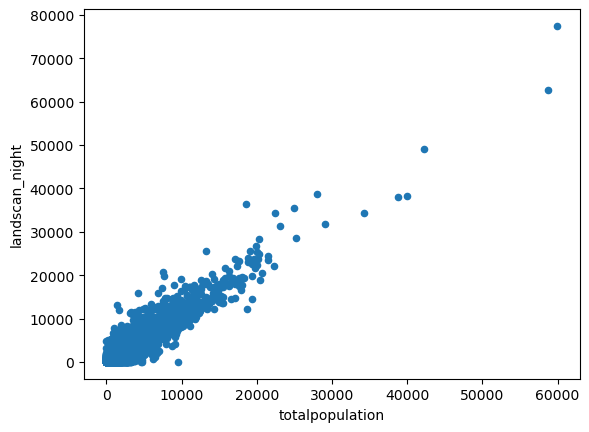

In [41]:
day_night_popu_df.plot.scatter(x='totalpopulation', y='landscan_night')

In [42]:
# day_night_popu_df['weighted_day_diff'].abs().sum()
# day_night_popu_df

In [43]:
day_night_popu_df['ACS_diff_ratio'] = (day_night_popu_df['totalpopulation'] - day_night_popu_df['landscan_night']) /  day_night_popu_df['landscan_night']
day_night_popu_df['weighted_ACS_diff_ratio'] = day_night_popu_df['ACS_diff_ratio'] * day_night_popu_df['night_weight']
day_night_popu_df

index           CBG  hourly_noon_popu  hourly_midnight_popu  \
0            0  010010201001        416.727273            632.318182   
1            1  010010201002        500.000000           1497.590909   
2            2  010010202001        116.727273            699.818182   
3            3  010010202002       2532.363636            918.772727   
4            4  010010203001        432.181818           2692.590909   
...        ...           ...               ...                   ...   
215222  215472  560459511001        272.500000           1218.318182   
215223  215473  560459511002        587.772727           1797.272727   
215224  215474  560459513001        611.545455           1196.000000   
215225  215475  560459513002       3859.636364           1145.045455   
215226  215476  560459513003        728.090909           1114.090909   

        month_day_count  weekday_count  landscan_day  landscan_night  \
0                    30             22         392.0           580.0   
1                    30             22         436.0          1194.0   
2                    30             22        1622.0           904.0   
3                    30             22        2566.0          1116.0   
4                    30             22         974.0          2254.0   
...                 ...            ...           ...             ...   
215222               30             22         951.0          1408.0   
215223               30             22         956.0          1798.0   
215224               30             22         803.0          1041.0   
215225               30             22        1489.0          1179.0   
215226               30             22        1255.0          1319.0   

        day_ratio  night_ratio  day_weight  weighted_day_ratio  night_weight  \
0        1.063080     1.090204    0.000001        1.267567e-06      0.000002   
1        1.146789     1.254264    0.000001        1.520859e-06      0.000004   
2        0.071965     0.774135    0.000005        3.550514e-07      0.000003   
3        0.986892     0.823273    0.000008        7.702734e-06      0.000003   
4        0.443718     1.194583    0.000003        1.314575e-06      0.000007   
...           ...          ...         ...                 ...           ...   
215222   0.286540     0.865283    0.000003        8.288680e-07      0.000004   
215223   0.614825     0.999596    0.000003        1.787839e-06      0.000005   
215224   0.761576     1.148895    0.000002        1.860148e-06      0.000003   
215225   2.592100     0.971201    0.000005        1.173992e-05      0.000004   
215226   0.580152     0.844648    0.000004        2.214647e-06      0.000004   

        weighted_night_ratio  day_diff_ratio  night_diff_ratio  \
0                   0.000002        0.063080          0.133465   
1                   0.000005        0.146789          0.696309   
2                   0.000002       -0.928035         -0.125883   
3                   0.000003       -0.013108         -0.076862   
4                   0.000008       -0.556282          0.450299   
...                      ...             ...               ...   
215222              0.000004       -0.713460         -0.199455   
215223              0.000005       -0.385175         -0.000761   
215224              0.000004       -0.238424          0.193026   
215225              0.000003        1.592100         -0.022804   
215226              0.000003       -0.419848         -0.163274   

        weighted_day_diff_ratio  weighted_night_diff_ratio  totalpopulation  \
0                  7.521338e-08               2.349213e-07              730   
1                  1.946699e-07               2.523100e-06             1263   
2                 -4.578614e-06              -3.453524e-07              835   
3                 -1.023123e-07              -2.603169e-07             1124   
4                 -1.648058e-06               3.080225e-06             2774   
...                         ...                    

# Results

In [44]:
print("relative difference (daytime, nighttime, LandScan_nighttime to ACS):")
day_night_popu_df['weighted_day_diff_ratio'].abs().sum(), day_night_popu_df['weighted_night_diff_ratio'].abs().sum(), day_night_popu_df['weighted_ACS_diff_ratio'].abs().sum()

relative difference (daytime, nighttime, LandScan_nighttime to ACS):


(0.635816316789724, 0.4308443750889861, 0.20640666359089213)

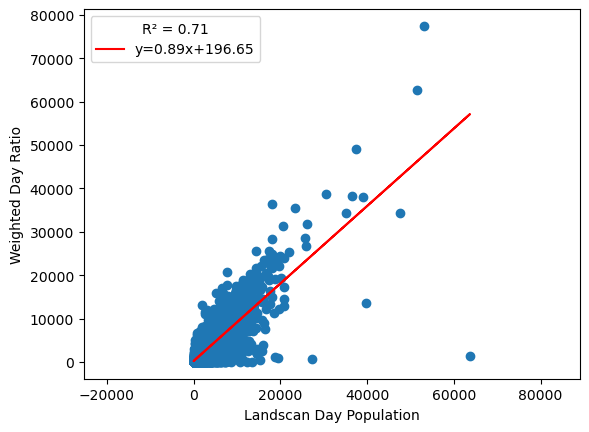

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Assuming 'day_night_popu_df' is already defined and contains 'landscan_day' and 'weighted_day_ratio'

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(day_night_popu_df.query("landscan_day < 500000")['hourly_midnight_popu'], day_night_popu_df.query("landscan_day < 500000")['landscan_night'])

# Create a line of best fit
line = slope * day_night_popu_df.query("landscan_day < 500000")['hourly_midnight_popu'] + intercept

# Plot the original scatter plot
plt.scatter(day_night_popu_df['hourly_midnight_popu'], day_night_popu_df['landscan_night'])

# Add the line of best fit
plt.plot(day_night_popu_df.query("landscan_day < 500000")['hourly_midnight_popu'], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')

# Add R^2 value in the legend
plt.legend(title=f'R² = {r_value**2:.2f}')

# Label the axes
plt.xlabel('Landscan Day Population')
plt.ylabel('Weighted Day Ratio')

plt.axis('equal')

# Show the plot
plt.show()


In [46]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
# landscan_df.query(" SUM > 0")

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Assuming 'day_night_popu_df' is already defined and contains 'landscan_day' and 'weighted_day_ratio'

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(day_night_popu_df.query("landscan_day < 500000")['hourly_noon_popu'], day_night_popu_df.query("landscan_day < 500000")['landscan_day'])

# Create a line of best fit
line = slope * day_night_popu_df.query("landscan_day < 500000")['hourly_noon_popu'] + intercept

# Plot the original scatter plot
plt.scatter(day_night_popu_df['hourly_noon_popu'], day_night_popu_df['landscan_day'])

# Add the line of best fit
plt.plot(day_night_popu_df.query("landscan_day < 500000")['hourly_noon_popu'], line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')

# Add R^2 value in the legend
plt.legend(title=f'R² = {r_value**2:.2f}')

# Label the axes
plt.xlabel('Landscan Day Population')
plt.ylabel('Weighted Day Ratio')

plt.axis('equal')

# Show the plot
plt.show()


In [ ]:
# merged_df['SUM'].describe()
# noon_popu_df.query(" noon_popu > 0").sum()
noon_popu_df.sum()
landscan_df.query(" SUM > 0")['SUM'].sum(), noon_popu_df.sum()

In [ ]:
# day_peak_popu_df = hourly_popu_df.iloc[:, day_hours].max(axis=1).reset_index()
# day_peak_popu_df.columns = ['CBG', 'day_peak_popu']
merged_df = noon_popu_df.reset_index().merge(landscan_df.query(" SUM > 0"), left_on='CBG', right_on='GEOID')
noon_popu_df.sum()

In [ ]:
merged_df['popu_diff'] = merged_df['noon_popu'] - merged_df['SUM']
merged_df['popu_diff_ratio'] = merged_df['popu_diff'] / merged_df['SUM']
merged_df['ratio'] = merged_df['noon_popu'] / merged_df['SUM']

print("ratio mean:", merged_df['ratio'].abs().mean())
merged_df

In [ ]:
print("Negative cell ratio:")
(hourly_popu_df<0).sum().sum() / (hourly_popu_df.shape[0] * hourly_popu_df.shape[1])#.min(axis=1)  # too many negtive values

In [ ]:
merged_df.query("noon_popu < 0")['noon_popu'].sum()
hourly_popu_df

# County difference

In [ ]:
merged_df['SUM'].sum(), merged_df['noon_popu'].sum()

In [ ]:
merged_df['county'] = merged_df['GEOID'].str[:5]
groupped = merged_df.groupby(['county'], as_index=False)[['noon_popu', 'SUM', 'popu_diff']].sum()

groupped['diff_ratio'] = groupped['popu_diff'] / groupped['SUM']
groupped['diff_ratio_abs'] = groupped['diff_ratio'].abs()

total_popu = groupped['SUM'].sum()
groupped['weight'] = groupped['SUM'] / total_popu
groupped['weighted_diff_ratio'] = groupped['diff_ratio_abs'] * groupped['weight']

groupped['ratio'] = (groupped['noon_popu'] / groupped['SUM']).abs()

print("County ratio:", groupped['ratio'].abs().mean())
print("County weighted_diff_ratio:", groupped['weighted_diff_ratio'].abs().mean())

groupped

In [ ]:
# merged_df['weighted_diff_ratio'].abs().sum(), merged_df['diff_ratio_abs'].mean()

In [ ]:
groupped.query("county == '36061' ")

In [ ]:
groupped['diff_ratio'].abs().mean(), groupped['weighted_diff_ratio'].sum()

In [ ]:
merged_df

In [ ]:
merged_df  = merged_df.query(" SUM > 0")
merged_df['diff_ratio'] = merged_df['popu_diff'] / merged_df['SUM']
merged_df['diff_ratio_abs'] = merged_df['diff_ratio'].abs()

total_popu = merged_df['SUM'].sum()
merged_df['weight'] = merged_df['SUM'] / total_popu
merged_df['weighted_diff_ratio'] = merged_df['diff_ratio_abs'] * merged_df['weight']

merged_df['ratio'] = (merged_df['noon_popu'] / merged_df['SUM']) 
merged_df['weighted_ratio'] = merged_df['ratio'] * merged_df['weight']


print("total_popu:", total_popu)
print("CBG ratio (absolute mean):", merged_df['ratio'].abs().mean())
print("CBG absolute weighted_ratio:", merged_df['weighted_ratio'].abs().sum())


merged_df

In [ ]:
merged_df['weighted_diff_ratio'].abs().sum(), merged_df['diff_ratio_abs'].mean()

In [ ]:
merged_df.sort_values('SUM').iloc[-1000:, :]#.sample(10)

In [ ]:
merged_df['weight'].sum(), merged_df['weighted_ratio'].abs().sum(), merged_df['noon_popu'].sum()

In [ ]:
merged_df['diff_ratio'].abs().mean(), merged_df['weighted_diff_ratio'].sum(), merged_df['weighted_ratio'].abs().sum(), merged_df['ratio'].abs().mean()